## Shimmering Effect in Guitar Pedals

Shimmering is an effect that is produced by expensive electric guitars like Strymon Bigsky. We replicate the shimmer effect by employing a simple framework that use a few agents that we build below. 
   
To those users who are unfamiliar with the Shimmer Effect, we request the users to visit the following YouTube link that demonstrates the effect:
* [Shimmer Effect by Ryan Lutton](https://www.youtube.com/watch?v=varwUhY0CuE)

IoTPy is all about connecting agents in a useful manner. To deal with acoustic data, we create agents that can process this acoustic data real-time in a useful way. For the purpose of the Shimmer Effect, we create three agents: 
* A Sum Agent for adding up data streams and merging them into one
* A Pitch Shift agent that shifts the pitch by a specific number of semitones / half an octave. 
* An Echo agent that creates echos.

To make the visualization a little easier, look the diagram below. The boxes are the agents and the connections are the streams. The heard sound is the Shimmer Effect that we will soon listen to!

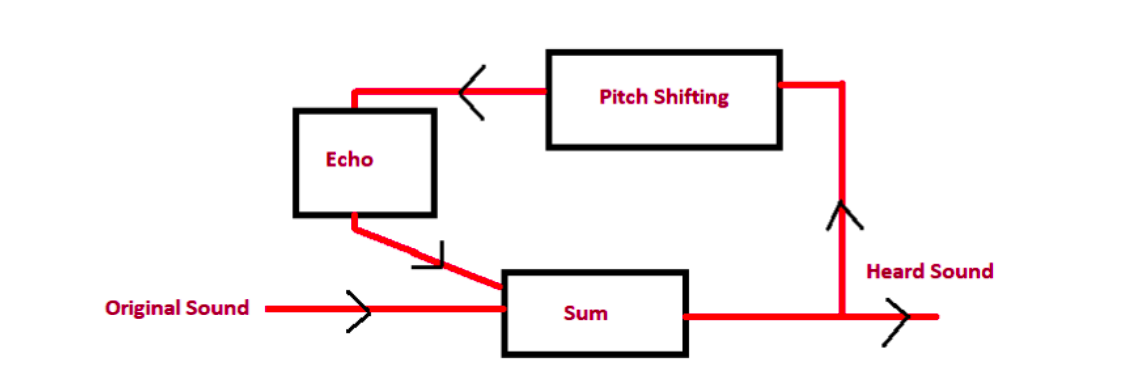


To begin with, let us import all the things needed for recreating the Shimmer Effect!

In [1]:
import sys
sys.path.append("../")
import numpy as np
from scipy.io import wavfile
from scipy.io.wavfile import read, write
import sounddevice as sd

### Pitch Shifting Agent

Pitch shifting involves changing the pitch of a given acoustic signal. A change in the pitch of
the signal corresponds to a change in the frequency of the signal. 

Pitch shifting has two main steps.
* The first step is where we stretch and mondify the sound signal, and 
* the second step is where we shrink the sound signal to preserve the duration of the acoustic signal. 

Sound stretching is done using the phase vocoder method in which one firstly breaks up the sound signal into a collection of overlapping chunks and then increases or decreases the overlapping region to accordingly shrink or stretch the sound. <br>
Because of this change in the overlap, the acoustic signal tends to lose its integrity due to a shift in the phase; using window functions, the signal is rephased and resynchronized.

The code below creates the Pitch Shifting Agent. 

We use StreamArray to create a Stream using IoTPy, run to run the process, and the sink window Agent type.

In [2]:
"""
This code is a streaming version of code written by Zulko who
created the 'pianoputer.' All the ideas are from Zulko's
version. All we do here is show how to convert code for an
array into code for a stream.

To play music, download sounddevice.

A problem encountered when switching from arrays to streams
is that code operating on an array can use metrics --- such as
maximum --- over the entire array, whereas code operating on
streams has to compute pitch shift based on the available
data up to that point. For the streaming version we assume
that the maximum over the entire array is 4096.0 (See the
last lines of stretch in which result is computed). A poor
assumption of the maximum may result in clipping or numerical
problems.

This code has both the original version (modified with max
assumed to be 4096) and the streaming version so that you
can see how one is converted into the other. speedx and
stretch are from the original version, while the method
Stretch.stretch is the streaming version.

The repository includes a short wav file called 'guitar.wav'
If you run test_pitchshift you will hear the sound shifted
to a lower pitch, then the original sound, and then the sound
shifted to a higher pitch. In each case you will first hear
the sound created by original version (modified by assuming
max is 4096) and the streaming version.

The streaming code was written by Deepak Narayanan and Mani
Chandy. The Stretch.stretch() function is based on Zulko's
code.

"""

#!/usr/bin/env python

#---------------------------------------------------------------------
# CODE FROM ZULKO, PIANOPUTER. MERELY FOR REFERENCE.
#---------------------------------------------------------------------

def speedx(sound_array, factor):
    """
    Multiplies the sound's speed by factor
    Taken from Zulko, pianoputer

    Parameters
    ----------
    sound_array: np.array
      The array that is being stretched
    factor: positive number
      The sound is speeded up when factor > 1.

    """
    indices = np.round( np.arange(0, len(sound_array), factor) )
    indices = indices[indices < len(sound_array)].astype(int)
    return sound_array[ indices.astype(int) ]


def stretch(sound_array, f, window_size, h):
    """
    Stretches the sound by a factor f.
    Taken from Zulko, pianoputer

    Parameters
    ----------
    sound_array: np.array
      The array that is being stretched
    f: positive number
      The amount of stretch when f > 1 and contraction if f < 1.
    window_size: int or float
      The sound_array is inspected by subarrays each of which is of
      size window_size.
    h: int or float
      The overlap between successive windows.
    """
    window_size = int(window_size)
    phase  = np.zeros(window_size)
    hanning_window = np.hanning(window_size)
    result = np.zeros( int(len(sound_array) /f + window_size))

   
    for i in np.arange(0, len(sound_array)-(window_size+h), int(h*f)):

        # two potentially overlapping subarrays
        a1 = sound_array[i: i + int(window_size)]
        a2 = sound_array[i + h: i + int(window_size) + int(h)]

        # resynchronize the second array on the first
        s1 =  np.fft.fft(hanning_window * a1)
        s2 =  np.fft.fft(hanning_window * a2)
        phase = (phase + np.angle(s2/s1)) % 2*np.pi
        a2_rephased = np.fft.ifft(np.abs(s2)*np.exp(1j*phase))

        # add to result
        i2 = int(i/f)
        result[i2 : i2 + window_size] += np.real((hanning_window*a2_rephased))
        
    #result = ((2**(16-4)) * result/result.max()) # normalize
    # Assume result.max() is 2**(16-4)x
    return result.astype('int16')

def pitchshift(sound_array, n, window_size=2**13, h=2**11):
    """
    Changes the pitch of a sound by n semitones.
    Taken from Zulko, pianoputer
    """
    factor = 2**(1.0 * n / 12.0)
    stretched = stretch(sound_array, 1.0/factor, window_size, h)
    return speedx(stretched[window_size:], factor)

#---------------------------------------------------------------------
# END OF CODE FROM ZULKO, PIANOPUTER
#---------------------------------------------------------------------


#---------------------------------------------------------------------
# CODE TO CONVERT OPERATION ON AN ARRAY TO OPERATION ON A STREAM.
#---------------------------------------------------------------------
def pitchshift_stream(sound_array, n, window_size=2**13, h=2**11):
    """
    Changes the pitch of a sound by n semitones.

    Notes
    -----
    This application has 2 sink_window agents and 3 streams x, y, z.
    Stretch agent: The first agent gets input x and outputs y which
    stretches the data in stream x. The stretching code is from Zulko,
    pianoputer. 
    Speed up agent: The next agent gets input y and outputs z which
    speeds up y by the specified factor. This agent interpolates the
    data in y to the number of points determined by factor.

    """
    factor = 2**(1.0 * n / 12.0)
    f = 1.0/factor

    # Declare streams
    x = StreamArray('x', dtype=np.int16)
    y = StreamArray('y', dtype=np.int16)
    z = StreamArray('z', dtype=np.int16)

    # Define the stretch agent
    stretch_object = Stretch(
        in_stream=x, out_stream=y, factor=factor,
        window_size=window_size, h=h) 
    sink_window(
        func=stretch_object.stretch, in_stream=x,
        window_size=window_size+h, step_size=int(h*f))

    # Define the speedup agent.
    def f(window, out_stream):
        indices = np.arange(0, window_size, factor)
        out_stream.extend(
            np.int16(np.interp(
                indices, np.arange(window_size), window))) 
    sink_window(func=f, in_stream=y, window_size=window_size,
    step_size=window_size, out_stream=z)

    # Partition sound_array into sound bites. Extend the
    # input with a sequence of sound bites and run each
    # sound bite until the sound_array data is finished.
    sound_bite_size = 2**14
    for i in range(0, sound_array.size, sound_bite_size):
        # sound_bite = sound_array[i:i+sound_bite_size]
        x.extend(sound_array[i:i+sound_bite_size])
        run()
    # Process any data in sound_array that wasn't processed
    # in the for loop.
    x.extend(sound_array[i:])

    # Return the result.
    return z.recent[:z.stop]

class Stretch(object):
    """
    Parameters
    __________

    """
    def __init__(self, in_stream, out_stream, factor, window_size, h):
        self.in_stream = in_stream
        self.out_stream = out_stream
        self.factor = factor
        self.f = 1.0/factor
        self.window_size = window_size
        self.h = h
        self.phase = np.zeros(window_size)
        self.hanning_window = np.hanning(self.window_size)
        self.result = np.zeros(window_size+h)
    def stretch(self, window):
        # -----------------------------------------------------
        # From Zulko stretch()
        # a1 and a2 are two overlapping subarrays, each of size
        # window_size with an overlap of h.
        a1 = window[:self.window_size]
        a2 = window[int(self.h): self.window_size+int(self.h)]

        # resynchronize the second array on the first
        s1 = np.fft.fft(self.hanning_window * a1)
        s2 = np.fft.fft(self.hanning_window * a2)
        self.phase = (self.phase + np.angle(s2/s1)) % 2*np.pi
        a2_rephased = np.fft.ifft(np.abs(s2)*np.exp(1j*self.phase))

        # Add resynchronized second array to result, and output
        # on out_stream. Recall that the size of self.result is
        # self.window_size + self.h.
        self.result[: self.window_size] += np.real(
            (self.hanning_window*a2_rephased))
        current_output = (self.result[:self.h]).astype(np.int16)
        self.out_stream.extend(current_output)

        # Save self.result[self.h : ] for next window.
        self.result = np.roll(self.result, -self.h)
        self.result[self.window_size:] = 0.0

### Make Echo or Echo Agent

This is a simple agent. 

For an input stream, we create an echo or a reverb agent by shifting the input stream by a delay and then adding an attenuated version of the original stream to the input stream.

An echo can be viewed as a dot product of a moving window. We define the window_dot_product function below that uses the map_window agent type to create an echo based on a moving window.


### Sum Agent

We just use IoTPy's zip_map agent type here.

In [3]:
from IoTPy.agent_types.basics import map_w## Putting all the agents together!

def window_dot_product(in_stream, out_stream, multiplicand_vector, step_size=1):
    """
    Parameters
    ----------
    in_stream: Stream
       input stream of agent
    out_stream: Stream
       output stream of agent
    multiplicand_vector: list or NumPy array
       length of multiplicand_vector must be strictly positive
       The dot product is applied between each sliding window
       and the multiplicand_vector
    step_size: int
       Must be positive
       The amount by which the sliding window moves on each step.

    Operation
    ---------
    Creates an agent which carries out the dot product of the
    multiplicand_vector and each sliding window.
    The window size is len(multiplicand_vector).

    """
    @map_w
    def f(window, multiplicand_vector): return np.dot(window, multiplicand_vector)
    f(in_stream, out_stream, len(multiplicand_vector), step_size,
      multiplicand_vector=multiplicand_vector)

## Putting all the agents together!

In [4]:
from IoTPy.core.stream import run
from IoTPy.core.stream import StreamArray, Stream
from IoTPy.helper_functions.recent_values import recent_values
from IoTPy.agent_types.sink import sink_window
from IoTPy.agent_types.merge import zip_map
from IoTPy.agent_types.basics import map_w

To make things easier to understand, the below cell uses only a single core. The idea in single core is that each agent executes one at a time. But as we can see, as soon as a stream is written, the agent attached to the stream can start executing given enough computational resource. In Multicore, we will demonstrate precisely this.

In [5]:
def shimmer(original_sound_list, fs):
    """
    Paramters
    ---------
    original_sound_list: Input Sound
    fs: Sampling Frequency
    """
    
    delay = int(fs/3)
    attenuation_vector = [0.6]
    input_stream = StreamArray('Input')
    heard = StreamArray('Output')
    pitch_out = StreamArray('PitchShift Output')
    
    echo = StreamArray(name='echo', initial_value=np.zeros(delay))
    # This below zip_map agent is the part that merges the output from Echo agent above and
    # The input stream
    zip_map(func=sum,
            in_streams=[input_stream, echo],
            out_stream= heard)
    
    # This below agent takes the output from the Pitch Shifter and then 
    # Creates the Echo out of that sound that is fed as input to the zip_map agent above
    window_dot_product(
        in_stream=pitch_out, out_stream=echo,
        multiplicand_vector=attenuation_vector)
    
    window_size=2**13
    h=2**11
    n = 12
    factor = 2**(1.0 * n / 12.0)
    f = 1.0/factor


    # Define the stretch agent    
    y = StreamArray('y', dtype=np.int16)
    
    # The below is the Pitch Shift Agent
    stretch_object = Stretch(
        in_stream= heard, out_stream=y, factor=factor,
        window_size=window_size, h=h) 
    
    sink_window(
        func=stretch_object.stretch, in_stream=heard,
        window_size=window_size+h, step_size=int(h*f))

    # Define the speedup agent.
    def f(window, out_stream):
        indices = np.arange(0, window_size, factor)
        out_stream.extend(
            np.int16(np.interp(
                indices, np.arange(window_size), window)) + 0.0) 
    sink_window(func=f, in_stream=y, window_size=window_size,
    step_size=window_size, out_stream=pitch_out)
    
    input_stream.extend(original_sound_list)
    run()
    return recent_values(heard)


Let us load the audio file and play it.

In [6]:
fs, original_sound_list = read("acoustics/guitar.wav")
original_sound_list_ = original_sound_list.astype(np.float)
sd.play(original_sound_list)

Let us time how long it takes for Shimmer Effect and let us play it.

In [7]:
%%time
heard = shimmer(original_sound_list_, fs)

CPU times: user 17.7 s, sys: 123 ms, total: 17.8 s
Wall time: 17.6 s


In [8]:
sd.play(np.int16(heard))

Let us do the same using multicore.

Sounddevice has some issues while dealing with multiprocess from Python. Therefore, we first write the generated acoustic effect to a file and then play it.

In [9]:
from IoTPy.concurrency.multicore import get_processes
from IoTPy.agent_types.sink import stream_to_file

In [10]:
def shimmer_multicore(original_sound_list, fs):
    
    delay = int(fs/3)
    attenuation_vector = [0.6]
    
    def echo_agent(in_streams, out_streams):
        """
        Notes
        -----
        For this particular function, there is only
        one input stream, which is the output of the pitchshifted
        agent. The output stream is the generated echo.
        """
        window_dot_product(
            in_stream = in_streams[0], 
            out_stream = out_streams[0],
        multiplicand_vector=attenuation_vector)
        
        
    def pitch_shift(in_streams, out_streams):
        
        """
        Notes
        -----
        For this particular function, there is only one
        input stream, that is the output of the shimmer effect.
        The output of this function is the pitchshifted version of the 
        heard stream.
        """
        window_size=2**13
        h=2**11
        n = 12
        factor = 2**(1.0 * n / 12.0)
        f = 1.0/factor


        # Define the stretch agent    
        y = StreamArray('y', dtype=np.int16)

        # The below is the Pitch Shift Agent
        stretch_object = Stretch(
            in_stream= in_streams[0], out_stream=y, factor=factor,
            window_size=window_size, h=h) 

        sink_window(
            func=stretch_object.stretch, in_stream=in_streams[0],
            window_size=window_size+h, step_size=int(h*f))

        # Define the speedup agent.
        def f(window, out_stream):
            indices = np.arange(0, window_size, factor)
            out_stream.extend(
                np.int16(np.interp(
                    indices, np.arange(window_size), window)) + 0.0) 
        sink_window(func=f, in_stream=y, window_size=window_size,
        step_size=window_size, out_stream=out_streams[0])
        
    def sum_echo_input(in_streams, out_streams):
        """
        Notes
        -----
        This function takes as input two streams: the input stream and the output of the 
        echo agent - i.e., the echo of the pitchshifted signal. It outputs
        one stream - the heard sound.
        """
        in_streams[1].extend(np.zeros(delay))
        zip_map(
        func = sum,
        in_streams = [in_streams[0], in_streams[1]], 
        out_stream = out_streams[0]
        )
        
    def write_file(in_streams, out_streams):
        stream_to_file(in_stream = in_streams[0],
                      filename='output.txt')
        
    def get_source_from_data(proc):
        proc.copy_stream(data = original_sound_list,
                         stream_name='Input Stream')
        proc.finished_source(stream_name='Input Stream')
    
    multicore_specification = \
    [
        # Streams
        [
            ('Input Stream', 'f'),
            ('Output Stream', 'f'),
            ('Pitch Output', 'f'),
            ('echo', 'f')
        ],
        
        # Processes
        [   # Each process runs in its own thread.
            # We create a process for each agent
            
            # Echo Agent's Process
            {
                'name':'Echo',
                'agent':echo_agent,
                'inputs':['Pitch Output'],
                'outputs':['echo']
            },
            
            # Pitchshift Agent's Process
            {
                'name':'PitchShift',
                'agent':pitch_shift,
                'inputs':['Output Stream'],
                'outputs':['Pitch Output']
            },
            
            # Summation Agent's Process
            {
                'name':'Sum_Echo_And_Input',
                'agent':sum_echo_input,
                'inputs':['Input Stream', 'echo'],
                'outputs':['Output Stream'],
            'sources':['Input Stream'], 'source_functions':[get_source_from_data]
            },
            
            {
                'name':'Write',
                'agent':write_file,
                'inputs':['Output Stream'],
                'outputs':[]
            }
        ]
        
    ]
    
    processes = get_processes(multicore_specification)
    
    for process in processes: process.start()
    for process in processes: process.join()    
    for process in processes: process.terminate()        

In [11]:
%%time
shimmer_multicore(original_sound_list_, fs)

CPU times: user 157 ms, sys: 76.7 ms, total: 234 ms
Wall time: 25.8 s


In [12]:
f = open("output.txt")
new = []
for i in f:
    new.append(float(i.strip()))
f.close()
new = np.array(new)
scaled = np.int16(new/np.max(np.abs(new))*32767)
sd.play(scaled)

CPU Time is far lower in multicore. 

Let us also try out another variant of multicore.

The gains do not seem substantial in terms of wall time.

In [13]:
def shimmer_multicore_1(sound_array, fs):

    attenuation_vector = [0.6]
    delay = int(fs/3)



    def sum_after_echo(in_streams, out_streams):

        echo = StreamArray(name='echo', initial_value=np.zeros(delay))

        zip_map(func=sum,
                in_streams=[in_streams[0], echo],
                out_stream= out_streams[0])

        window_dot_product(
            in_stream=in_streams[1], out_stream=echo,
            multiplicand_vector=attenuation_vector)



    def pitchshifting(in_streams, out_streams):

        window_size=2**13
        h=2**11
        n = 12
        factor = 2**(1.0 * n / 12.0)
        f = 1.0/factor

        # Declare streams
        y = Stream()

        # Define the stretch agent
        stretch_object = Stretch(
            in_stream=in_streams[0], out_stream=y, factor=factor,
            window_size=window_size, h=h) 
        sink_window(
            func=stretch_object.stretch, in_stream=in_streams[0],
            window_size=window_size+h, step_size=int(h*f))

        # Define the speedup agent.
        def f(window, out_stream):
            indices = np.arange(0, window_size, factor)
            out_stream.extend(
                np.int16(np.interp(
                    indices, np.arange(window_size), window))) 
        sink_window(func=f, in_stream=y, window_size=window_size,
        step_size=window_size, out_stream=out_streams[0])

    def write_to_file(in_streams, out_streams):
        stream_to_file(in_stream=in_streams[0], filename='output2.txt')

    def get_source_from_data(proc):
        proc.copy_stream(data = original_sound_list,
                         stream_name='Input Stream')
        proc.finished_source(stream_name='Input Stream')

    def get_source_from_data(proc):
        proc.copy_stream(data = original_sound_list,
                         stream_name='Input Stream')
        proc.finished_source(stream_name='Input Stream')

    multicore_specification = \
    [
        # Streams
        [
            ('Input Stream', 'f'),
            ('Output Stream', 'f'),
            ('Pitch Output', 'f'),
        ],
        
        # Processes
        [   # Each process runs in its own thread.
            # We create a process for each agent
                        
            # Pitchshift Agent's Process
            {
                'name':'PitchShift',
                'agent':pitchshifting,
                'inputs':['Output Stream'],
                'outputs':['Pitch Output']
            },
            
            # Summation Agent's Process
            {
                'name':'Sum_Echo_And_Input',
                'agent':sum_after_echo,
                'inputs':['Input Stream', 'Pitch Output'],
                'outputs':['Output Stream'],
            'sources':['Input Stream'], 'source_functions':[get_source_from_data]
            },
            
            {
                'name':'Write',
                'agent':write_to_file,
                'inputs':['Output Stream'],
                'outputs':[]
            }
        ]
        
    ]
    
    processes = get_processes(multicore_specification)
    for process in processes: process.start()
    for process in processes: process.join()
    for process in processes: process.terminate()

    

In [14]:
%%time
shimmer_multicore_1(original_sound_list_, fs)

CPU times: user 149 ms, sys: 72.7 ms, total: 222 ms
Wall time: 51.8 s


In [15]:
f = open("output2.txt")
new = []
for i in f:
    new.append(float(i.strip()))
f.close()
new = np.array(new)
scaled = np.int16(new/np.max(np.abs(new))*32767)
sd.play(scaled)